# 🦷 **Oral Cancer Image Analysis Workshop**

Welcome to the **Week 2: Image Representation & Feature Extraction** lab.  
This notebook complements the lecture and provides hands-on practice with oral cancer image analysis.

By the end of this assignment, you will understand:

1. **How computers "see" images** – as numerical matrices and vectors in high-dimensional space.
2. **Feature extraction techniques** – mimicking clinical observations like color (red/white patches), texture (irregular surfaces), and edges (ulcers/sores).
3. **Challenges like the curse of dimensionality** – and how techniques like PCA help mitigate them.
4. **Building a simple diagnosis pipeline** - using handcrafted features with linear scoring and decision trees.
5. **Limitations of handcrafted approaches** – and why more advanced methods (e.g., deep learning) are often needed.

👉 Some cells contain a `# fill this line of code` marker. These are left blank intentionally to make the learning **interactive**.



Note: This lab assumes you're running it in Google Colab or a similar environment with access to Git and necessary libraries.

### Import Required Libraries

We use standard Python libraries for image processing, numerical operations, and visualization. Each library serves a specific purpose:

- os: For file and directory handling.



- cv2 (OpenCV): For loading and processing images.



- numpy: For numerical operations on image data (e.g., matrix manipulation).



- matplotlib.pyplot: For visualizing images and plots.



- scipy.spatial.distance: For computing distances between images.



- skimage.feature: For texture feature extraction (e.g., Local Binary Patterns).



- sklearn.decomposition: For dimensionality reduction (PCA).



- sklearn.datasets: For generating synthetic data to demonstrate concepts.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

## **1. Dataset Setup**

Before we analyze images, we need a dataset.  

In this notebook, we will use a small dataset of oral cancer and healthy tissue images.  
The dataset is organized into **two classes**:

- **Normal** (healthy tissue)  
- **Cancer** (cancerous tissue)

Let’s begin by downloading and preparing the dataset.

### Clone the dataset from GitHub

We use git clone to download the dataset. This command fetches the dataset from a public repository into your working environment (e.g., Google Colab).

In [2]:
!git clone https://github.com/bishram-acharya/oc_data.git

Cloning into 'oc_data'...
remote: Enumerating objects: 1984, done.
remote: Total 1984 (delta 0), reused 0 (delta 0), pack-reused 1984 (from 1)
Receiving objects: 100% (1984/1984), 586.05 MiB | 20.94 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (1976/1976), done.


### Define the dataset path

Set the path to the training data directory.

In [3]:
dataset_path =  "oc_data"

### Inspect available classes

In [4]:
# Print the subdirectories in the dataset path to confirm "Normal" and "Cancer" folders
print(os.listdir(dataset_path))

['.git', 'Train', 'Test']


Task: Write a function to count the number of images in each class (Normal and Cancer).

In [5]:
import os
print(os.listdir("oc_data"))

['.git', 'Train', 'Test']


In [6]:
def count_images(dataset_path):
    for split in ["Train", "Test"]:
        split_path = os.path.join(dataset_path, split)
        for folder in ["Normal", "Cancer"]:
            folder_path = os.path.join(split_path, folder)
            num_images = len(os.listdir(folder_path))
            print(f"{split}/{folder}: {num_images} images")

count_images(dataset_path)

Train/Normal: 624 images
Train/Cancer: 1054 images
Test/Normal: 111 images
Test/Cancer: 187 images


## **2. Image Loading & Visualization**

 Visual inspection helps us:

- Verify that the dataset has been loaded correctly.  
- Understand differences between classes (Normal vs Oral Cancer).  
- Build intuition about what features (color, texture, shape) might be useful.


### Define helper functions

We define two functions to streamline image loading and visualization:





- load_image: Loads an image and converts it from BGR (OpenCV’s default) to RGB for correct color display.



- show_images: Displays multiple images in a grid for easy comparison.

In [7]:
def load_image(img_path):
    """Load an image from a path and convert it to RGB."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [8]:
def show_images(img_paths, titles=None, cols=5):
    """Display a set of images in a grid."""
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(img_paths):
        img = load_image(img_path)
        plt.subplot(1, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
        if titles:
            plt.title(titles[i])
    plt.show()

### View sample images

Load and display one Normal and one Cancer image to compare their visual characteristics.

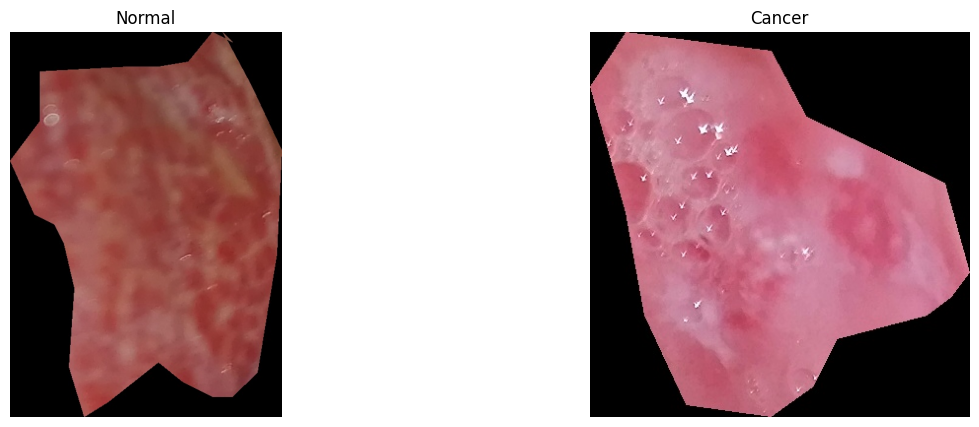

In [9]:
cancer_path = os.path.join(dataset_path, "Train", "Cancer", os.listdir(os.path.join(dataset_path, "Train", "Cancer"))[0])
normal_path = os.path.join(dataset_path, "Train", "Normal", os.listdir(os.path.join(dataset_path, "Train", "Normal"))[0])

show_images([normal_path, cancer_path], titles=["Normal", "Cancer"], cols=2)

👉 Questions to consider:

- What visual differences do you notice between the Normal and Cancer samples?

- Which of these differences might be captured by features like color or texture?

## **3. How do Computers 'See' Images?**

Humans perceive **patterns, textures, and objects**, but computers do not “see” images the same way.  

To a computer, an image is just a **matrix of numbers** representing pixel intensity values.

- **Grayscale image** → N × M matrix (height × width)  
- **RGB image** → N × M × 3 tensor (height × width × channels)

These numbers represent pixel intensity values, usually in the range 0–255.

Images are vectors in high-dimensional space (e.g., a 100×100 image is 10,000D). Flattening enables math operations but loses spatial info.

### Load a sample image

Choose an image from either the "Normal" or "Cancer" class to examine its numerical representation.

In [10]:
sample_class = "Normal"  # or "Cancer"
sample_image_path = os.path.join(dataset_path, "Train", sample_class, os.listdir(os.path.join(dataset_path, "Train", sample_class))[0])

img = cv2.imread(sample_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Display RGB vs. Grayscale

Visualize the image in both RGB and grayscale to see the effect of reducing color information.

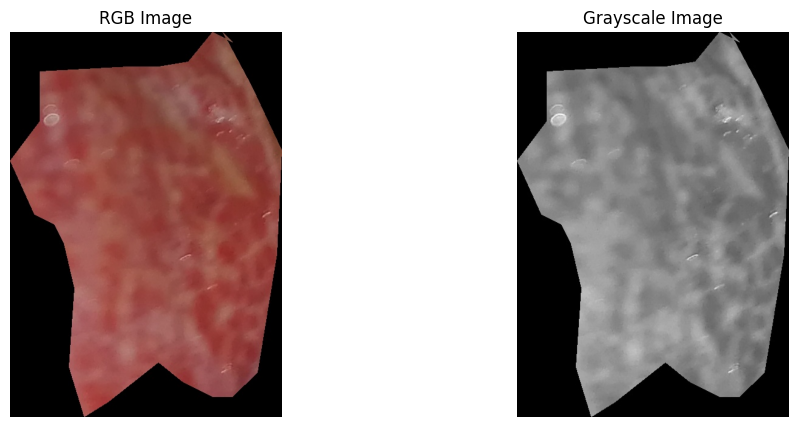

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title('RGB Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.show()

Grayscale images reduce dimensionality (from 3 channels to 1), which simplifies computations while retaining key structural information.

### Examine the numerical representation

Print the shape and pixel value range to understand the image’s numerical structure.

In [12]:
print("RGB image shape:", img_rgb.shape)         # (Height, Width, 3)
print("Grayscale image shape:", img_gray.shape)  # (Height, Width)
print("RGB pixel range:", img_rgb.min(), "to", img_rgb.max())
print("Grayscale pixel range:", img_gray.min(), "to", img_gray.max())

RGB image shape: (636, 448, 3)
Grayscale image shape: (636, 448)
RGB pixel range: 0 to 233
Grayscale pixel range: 0 to 186


- The shape tells us the size and number of channels in the image.

- The pixel values are numbers between 0–255 (8-bit images).

- Computers operate on these numbers to extract features.

### Visualize pixel intensity distribution

Plot a histogram of grayscale pixel intensities to see their distribution, excluding zero values which is the background in this case.

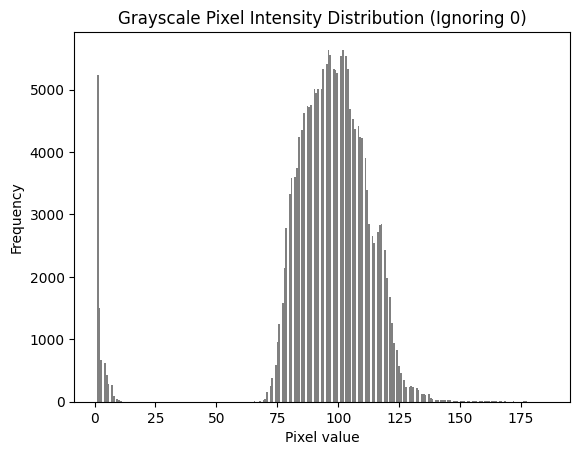

In [13]:
# Flatten grayscale image and ignore zero values
pixels = img_gray.ravel()
pixels_nonzero = pixels[pixels > 0]
plt.hist(pixels_nonzero, bins=256, color='gray')
plt.title("Grayscale Pixel Intensity Distribution (Ignoring 0)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

### Inspect a small patch

Extract and display a 5x5 pixel patch from the image center to see numerical values directly.

Pixel values of center patch (5x5):
 [[88 88 88 87]
 [88 88 87 87]
 [88 87 86 87]
 [87 86 87 88]]


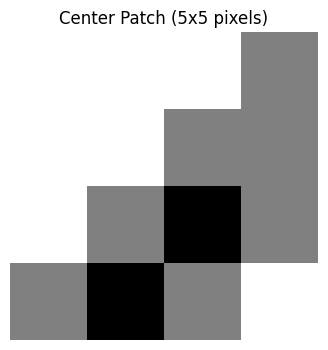

In [14]:
# Image dimensions
height, width = img_gray.shape

# Define a 5x5 patch around the center
patch_size = 5
center_row, center_col = height // 2, width // 2

patch = img_gray[center_row-patch_size//2 : center_row+patch_size//2,
                 center_col-patch_size//2 : center_col+patch_size//2]

print(f"Pixel values of center patch ({patch_size}x{patch_size}):\n", patch)

# Display the patch
plt.figure(figsize=(4,4))
plt.imshow(patch, cmap='gray')
plt.title(f"Center Patch ({patch_size}x{patch_size} pixels)")
plt.axis('off')
plt.show()


## Flattening Images
Convert the 2D patch to a 1D vector, which is often required for machine learning algorithms.

In [15]:
patch_flattened = patch.ravel()  # or patch.flatten()

print("Flattened patch shape:", patch_flattened.shape)
print("Flattened patch values:\n", patch_flattened)

Flattened patch shape: (16,)
Flattened patch values:
 [88 88 88 87 88 88 87 87 88 87 86 87 87 86 87 88]


Flattening transforms images into vectors, enabling mathematical operations like distance calculations, but it discards spatial relationships between pixels.

## **4. Comparing Images – Why Raw Pixel Distance Can Be Misleading**

To compare images, we can compute the Euclidean distance between their pixel values in high-dimensional space. If two images are identical, the distance is 0; larger distances indicate greater differences.

However, raw pixel comparisons can be misleading due to variations in lighting, alignment, or noise.


## Compare two images from the same class

Load and compare two images from the same class to see how similar they are.

In [16]:
# Load a second image from the same class (Train split)
another_image_path = os.path.join(dataset_path, "Train", sample_class, os.listdir(os.path.join(dataset_path, "Train", sample_class))[1])
img2 = cv2.imread(another_image_path, cv2.IMREAD_GRAYSCALE)

In [17]:
# Resize to match the first image
img2 = cv2.resize(img2, (img_gray.shape[1], img_gray.shape[0]))

Visualizing both images helps confirm they belong to the same class and highlights any subtle differences.

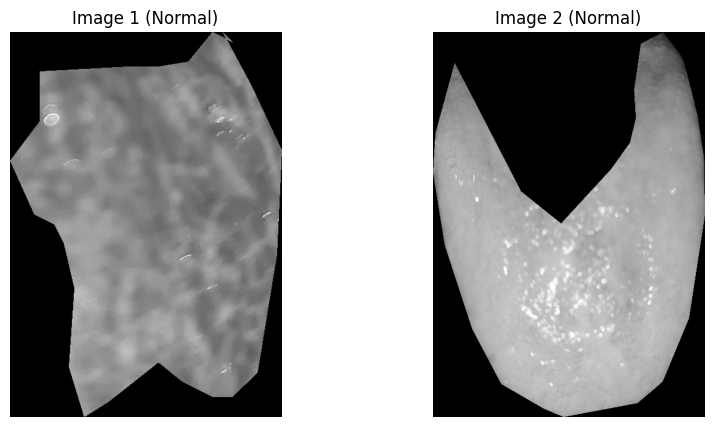

In [18]:
# Visualize both images
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title(f"Image 1 ({sample_class})")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')
plt.title(f"Image 2 ({sample_class})")
plt.axis('off')

plt.show()


In [31]:
# Flatten both images to 1D vectors
vec1 = img_gray.flatten()
vec2 = img2.flatten()

In [32]:
from scipy.spatial.distance import euclidean
# Compute Euclidean distance
dist = euclidean(vec1, vec2)
print("Euclidean distance between the two images:", dist)

Euclidean distance between the two images: 72986.60941570035


The Euclidean distance measures the difference between pixel intensities. A smaller distance suggests the images are more similar, but variations (e.g., lighting, alignment) can inflate this distance even within the same class.

### Compare images from different classes

Now compare a Normal and a Cancer image to see if cross-class distances are larger.

In [33]:
# Load one Normal image from Train split
normal_path = os.path.join(dataset_path, "Train", "Normal", os.listdir(os.path.join(dataset_path, "Train", "Normal"))[0])
img_normal = cv2.imread(normal_path, cv2.IMREAD_GRAYSCALE)

In [34]:
# Load one Cancer image
cancer_path = os.path.join(dataset_path, "Train", "Cancer", os.listdir(os.path.join(dataset_path, "Train", "Cancer"))[0])
img_cancer = cv2.imread(cancer_path, cv2.IMREAD_GRAYSCALE)

In [35]:
# Resize images to match
img_cancer = cv2.resize(img_cancer, (img_normal.shape[1], img_normal.shape[0]))

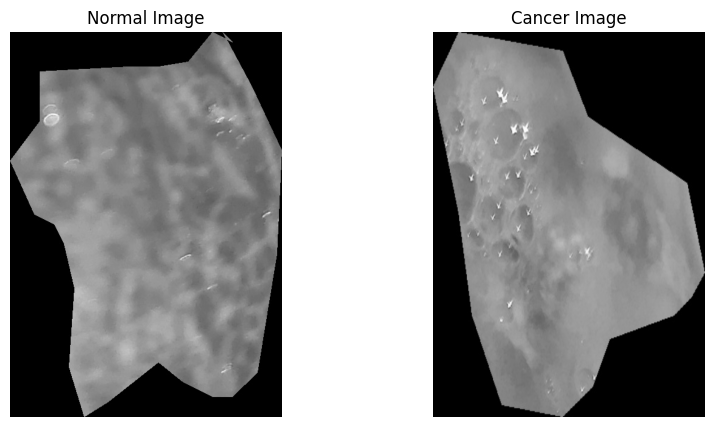

In [36]:
# Visualize both images
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_normal, cmap='gray')
plt.title("Normal Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_cancer, cmap='gray')
plt.title("Cancer Image")
plt.axis('off')

plt.show()

In [37]:
# Flatten images and compute Euclidean distance
vec_normal = img_normal.flatten()
vec_cancer = img_cancer.flatten()
dist_cross_class = euclidean(vec_normal, vec_cancer)
print("Euclidean distance between Normal and Cancer image:", dist_cross_class)

Euclidean distance between Normal and Cancer image: 87048.0640910526


 Surprisingly, the distance between two images of the same class may sometimes be larger than the distance between Normal and Cancer images. This happens because raw pixel values are sensitive to irrelevant variations (e.g., brightness, rotation), making them unreliable for classification.

 This demonstrates the need for feature extraction to focus on clinically relevant properties (e.g., texture, color) rather than raw pixels.

## **5. Feature Extraction**
Doctors analyze oral tissue using three main visual cues:

1. **Color:** Abnormal tissue often looks redder.

2. **Texture:** Cancerous tissue often has irregular or rough patterns.

3. **Shape:** Changes in structure, edges, or borders can be informative.

We’ll extract computational features to replicate these observations, focusing on redness (color) and texture (via Local Binary Patterns).


**5.1 Color Feature – Redness**

Cancerous tissue often has higher red intensity compared to healthy tissue. We’ll compute a histogram of the red channel to analyze its intensity distribution, which can reveal differences between Normal and Cancer images.



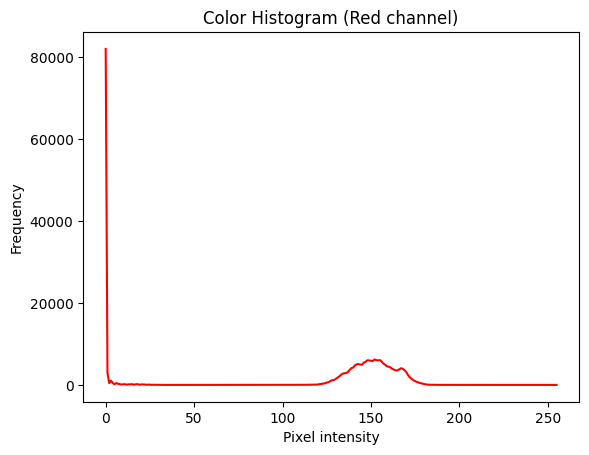

In [38]:
# Compute Red channel histogram
color_hist = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])

plt.plot(color_hist, color='r')
plt.title('Color Histogram (Red channel)')
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")
plt.show()


- The histogram shows how many pixels have each red intensity value (0 = no red, 255 = maximum red).


- Peaks at higher intensities suggest redder tissue, which may indicate cancerous areas.



- Normal tissue typically has lower or more uniform red intensities.



Redness is a clinically relevant feature, as inflamed or cancerous tissue often appears redder than healthy tissue.



**5.2 Texture Feature – Local Binary Pattern (LBP)**

Texture captures patterns like roughness or irregularity, which are common in cancerous tissue. **Local Binary Pattern (LBP)** compares each pixel to its neighbors, encoding their intensity relationships as a binary code. This highlights local patterns (e.g., edges, spots) that may differ between Normal and Cancer images.

In [39]:
from skimage.feature import local_binary_pattern
import numpy as np

# Parameters
radius = 10
n_points = 8 * radius

# Compute LBP (captures local texture patterns)
lbp = local_binary_pattern(img_gray, n_points, radius, method="uniform")

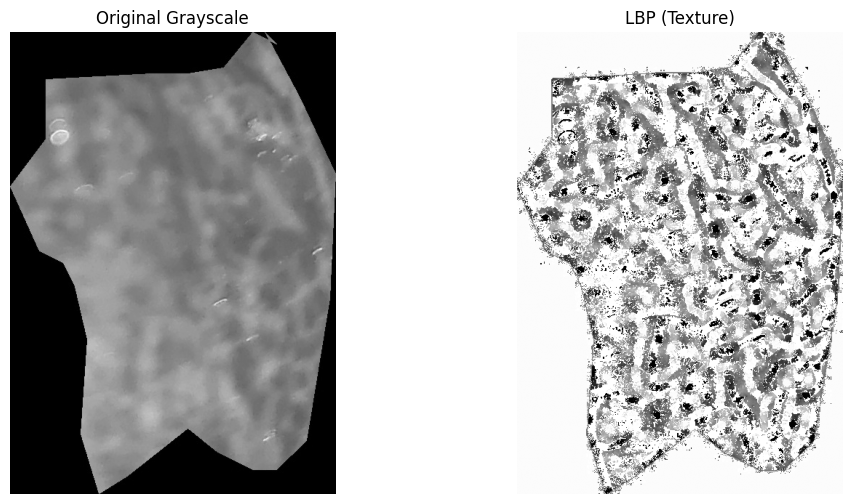

In [40]:
# Visualize original vs LBP
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title("Original Grayscale")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(lbp, cmap='gray')
plt.title("LBP (Texture)")
plt.axis("off")
plt.show()

LBP assigns each pixel a value based on whether its neighbors are brighter or darker, creating a texture map. Bright or dark regions in the LBP image indicate distinct patterns (e.g., rough or irregular surfaces). Cancerous tissue may show more varied or chaotic LBP patterns compared to smoother healthy tissue.



Texture is a key diagnostic feature, as cancerous tissue often has irregular surfaces or spots that LBP can capture.

## **6. Why Feature Comparison Can Be Tricky**

As we extract more features (e.g., redness, texture), the data becomes high-dimensional. In high-dimensional spaces, data points become sparse, and simple metrics like Euclidean distance become less reliable (the curse of dimensionality). Principal Component Analysis (PCA) reduces dimensionality while preserving important patterns, making data easier to visualize and analyze.

We’ll demonstrate this with a synthetic dataset, as real image features require more preprocessing.

In [41]:
# Synthetic dataset: 200 samples, 50 features, 3 classes
X, y = make_classification(n_samples=200, n_features=50, n_informative=5, n_classes=3, random_state=42)


In [42]:
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

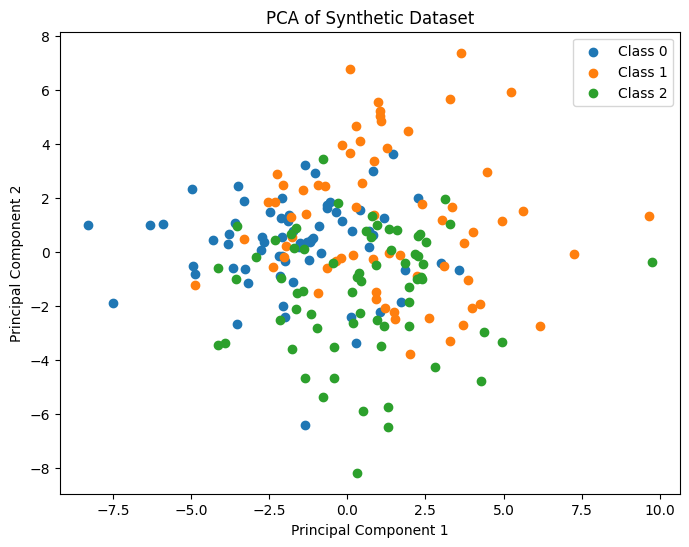

In [44]:
plt.figure(figsize=(8,6))
for cls in np.unique(y):
    plt.scatter(X_pca[y==cls, 0], X_pca[y==cls, 1], label=f"Class {cls}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Synthetic Dataset")
plt.legend()
plt.show()

- PCA finds the directions (principal components) with the most variance in the data and projects the data onto a lower-dimensional space (here, 2D).



- The scatter plot shows how samples are distributed in this reduced space, with colors indicating different classes.



- In real image analysis, PCA could reduce thousands of pixel or feature values to a few components for visualization or classification.

PCA helps visualize high-dimensional data and reduces computational complexity, making it easier to identify patterns or clusters (e.g., Normal vs. Cancer).

## **7. Handcrafted Risk Score & Simple Diagnosis**

In medical imaging, doctors diagnose oral cancer by observing visual cues like redness, irregular textures, and abnormal shapes in tissue images. To mimic this process computationally, we’ll create a handcrafted risk score by combining two features: redness (based on color) and roughness (based on texture). These features are inspired by clinical observations:





- Redness: Cancerous or inflamed tissue often appears redder due to increased blood flow or abnormal cell growth.



- Roughness: Cancerous tissue may have irregular or rough surfaces, unlike the smoother texture of healthy tissue.

We’ll compute these features, combine them into a single risk score, and use a simple threshold to classify an image as high risk or low risk for oral cancer. This approach demonstrates a basic diagnostic pipeline but also highlights the limitations of handcrafted features, paving the way for more advanced methods like machine learning or deep learning.

### Why use a Risk Score?

A risk score simplifies complex image data into a single number that estimates the likelihood of disease. By combining multiple features (redness and roughness), we aim to capture different aspects of oral cancer’s appearance. However, choosing which features to include and how to weight them is subjective and requires tuning, which is a key limitation of this approach.

In [45]:
# Define parameters for texture analysis using LBP
P = 8  # Number of neighboring pixels to compare (8 for a circular neighborhood)
R = 1  # Radius of the neighborhood (1 pixel away from the center pixel)
METHOD = 'uniform'  # Use 'uniform' patterns to reduce noise and dimensionality in LBP

### Compute redness

In [46]:
# Extract individual color channels from the RGB image as floating-point arrays
# - Converting to float allows precise calculations
r = img_rgb[:, :, 0].astype(float)  # Red channel
g = img_rgb[:, :, 1].astype(float)  # Green channel
b = img_rgb[:, :, 2].astype(float)  # Blue channel

In [47]:
# Calculate redness: measure how much red dominates over green and blue
# - Compute difference: red - (green + blue)/2
# - np.clip ensures negative values (non-red areas) are set to 0
# - Take the mean across all pixels and normalize by 255 to get a 0–1 range
redness = np.mean(np.clip(r - (g + b)/2, 0, 255)) / 255

### Compute Roughness using LBP

In [48]:
# Convert RGB image to grayscale, as LBP analyzes intensity, not color
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

In [49]:
#Compute LBP to capture local texture patterns (e.g., edges, spots, roughness)
# - LBP compares each pixel to its neighbors, producing a texture map
lbp = local_binary_pattern(gray, P, R, METHOD)

In [50]:
# Calculate roughness: normalized standard deviation of LBP values
# - Standard deviation measures texture variability (high = rough, low = smooth)
# - Normalize by maximum LBP value to ensure consistency across images
roughness = np.std(lbp) / np.max(lbp)

### Compute Risk Score

In [51]:
# Combine redness and roughness into a risk score using heuristic weights
# - Weight of 0.5 for redness emphasizes its clinical importance (inflammation)
# - Weight of 0.3 for roughness reflects texture’s secondary role
# - Sum creates a score between 0 and 1 (higher = more likely cancerous)
risk_score = (0.5 * redness) + (0.3 * roughness)

In [52]:
# Print intermediate values to understand feature contributions
print('Redness:', round(redness, 3))  # Normalized redness value
print('Roughness:', round(roughness, 3))  # Normalized texture variability
print('Risk Score:', round(risk_score, 3))  # Combined score

Redness: 0.209
Roughness: 0.252
Risk Score: 0.18


### Diagnosis

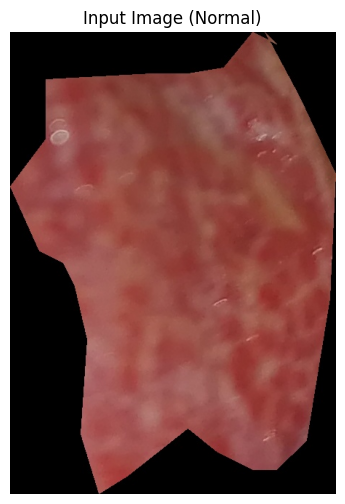

Diagnosis: Low Risk


In [53]:
#Display the RGB image to confirm which image is being analyzed
plt.figure(figsize=(6, 6))  # Set figure size for clear visualization
plt.imshow(img_rgb)  # Display the input RGB image
plt.title(f"Input Image ({sample_class})")  # Title with class (Normal/Cancer)
plt.axis('off')  # Hide axes for cleaner display
plt.show()

# Classify the image using a simple threshold
# - Threshold of 0.6 is arbitrary; in practice, it would be tuned using labeled data
# - High risk suggests potential cancerous tissue; low risk suggests healthy tissue
if risk_score > 0.6:
    print('Diagnosis: High Risk of Oral Cancer')
else:
    print('Diagnosis: Low Risk')

### Understanding the Output


- **Input Image:** The displayed image shows the tissue being analyzed, helping you connect visual features (e.g., red patches, irregular texture) to the computed risk score.


- **Redness (0–1):** A higher value indicates more intense red areas, which may correspond to inflammation or cancerous tissue.


- **Roughness (0–1):** A higher value indicates more irregular texture, often seen in cancerous tissue with rough or spotty surfaces.


- **Risk Score (0–1):** Combines the features to estimate cancer risk. A higher score suggests a greater likelihood of abnormality.


- **Diagnosis:** The threshold (0.6) splits images into high or low risk. This mimics a doctor’s decision-making but is overly simplistic.

👉 **Questions to Consider**

- How do the visual features (e.g., red patches, rough texture) in the displayed image align with the computed redness and roughness values?

- How might different weights for redness and roughness affect the risk score?

- Why might the threshold of 0.6 fail for images with different lighting or resolution?

- What other features (e.g., edge sharpness, lesion size) could improve the diagnosis?